# Data Inspection
Using forward scattering information.

In [1]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *

# Functions to load the time domain data, transform it to the FFT space, PCA space, etc...

In [2]:
def load_data(npoints, folder_path = "D:data OT//"):
    """
    Load the data, added targets2 for making a pool for the stratified 
    cross-validation procedure
    """

    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    target_fix=[]
    particle_group=[]
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data


    for i in range(0,len(path_files_TD)):


        current_path = path_files_TD[i]

        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        
        #max n_segments possible
        n_segments = int(len(current_df[0])/npoints)
        
        xx = np.array(current_df[0])[0:n_segments*npoints]
        yy = np.array(current_df[1])[0:n_segments*npoints]
        sums = np.array(current_df[2])[0:n_segments*npoints]

        #alterei isto que me estava a dar problemas com segmentos de tamanho variável
        x_data.append(np.array([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        y_data.append(np.array([yy[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        sum_data.append(np.array([sums[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        target_fix.append(current_path.split('//')[-1].split('.')[0][:-1])

        print(current_path + " Read "+ str(n_segments) + " segments", end = '\r')

        for i in range(0,int(len(xx)/npoints)):

            target.append(current_path.split('//')[-1].split('.')[0][:-1])
            
            #this will create a new index that corresponds to particle number, to be grouped in the cross-validation strategy
            particle_group.append(current_path.split('//')[-1].split('.')[0][-1:])


    return target, np.array(x_data), np.array(y_data), np.array(sum_data), np.array(particle_group),target_fix


def preprocess_data_fft(x_data, y_data, sum_data, target):
    
    """
    Computes the fft for each data, labels, dummy_labels and unique_targets list
    """
    data_X= []
    data_Y = []
    data_Sum = []
    #remove the continuum component
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_X.append(np.abs(fft_x))
            data_Y.append(np.abs(fft_y))
            data_Sum.append(np.abs(fft_sum))
            

    data_X=np.array(data_X)
    data_Y=np.array(data_Y)
    data_Sum=np.array(data_Sum)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        
        labels.append(np.where(target[i]==unique_targets)[0][0])
        
        
        #dummy
        index = np.where(target[i]==unique_targets)[0][0]
        arr = np.zeros(len(unique_targets))
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets

# Load the data

In [3]:

folder = "D:data OT - TT//TotalData//"
npoints   =  5000
target, x_data, y_data, sum_data, particle_group,target_fix = load_data(npoints, folder)


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets = preprocess_data_fft(x_data, y_data, sum_data, target)

# Transient Fit

<IPython.core.display.Javascript object>


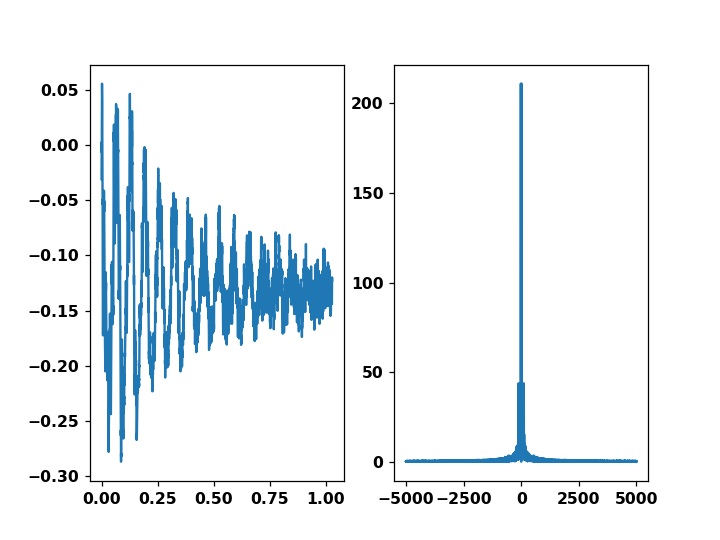

In [6]:
%matplotlib notebook
ind=0
dt=1e-4
signal=np.ndarray.flatten(x_data[ind])[1323050:1333330]
t=np.arange(0,len(signal))*dt
subplots()
subplot(121)
plot(t,signal)
subplot(122)

fft_s = fft.fft(signal)
fft_s[0]=0
fft_s = fft.fftshift(fft_s)

freqs = fft.fftshift(fft.fftfreq(len(signal),dt))
plot(freqs,abs(fft_s))

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: scipy.cos is deprecated and will be removed in SciPy 2.0.0, use numpy.cos instead
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


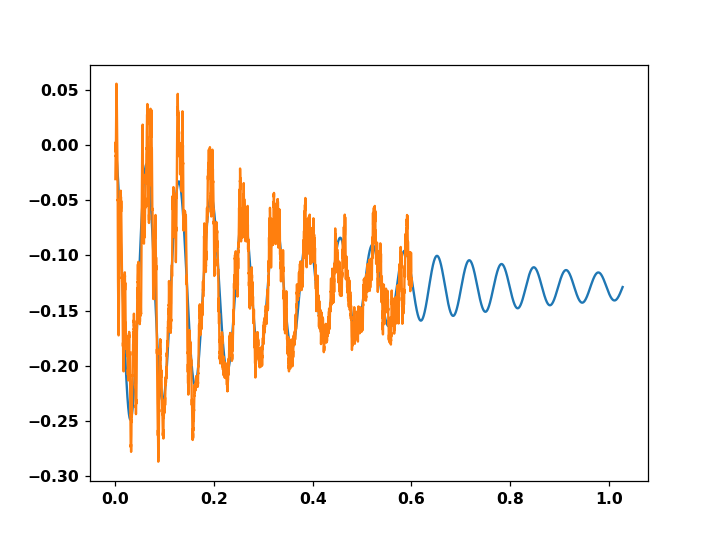

gamma/2m = -96.0965257519794
sqrt(k/m) = -0.12861063808051135


In [9]:
from scipy import optimize
def f(t,a,b,w,c0,phase):
    return c0+a*exp(-b*t)*cos(w*t+phase)

end=6000
t1=t[:end]
signal1=signal[:end]
p,o = optimize.curve_fit(f, t1, signal1)
subplots()
plot(t, f(t,p[0],p[1],p[2],p[3],p[4]))
#plot(t, f(t,0.19,2.5,2*pi*15,-0.12))
plot(t1,signal1)
print('gamma/2m = ' + str(p[2]))
print('sqrt(k/m) = ' + str(p[3]))

# Brownian Motion 2d

In [ ]:
from scipy.stats import *
%matplotlib notebook
subplots(figsize=[9,4])

end = 30000

for ind in range(0,len(x_data),6):
    subplot(3,len(x_data)/6,ind/6+1)
    
    x_d = np.ndarray.flatten(x_data[ind])[:end]
    y_d = np.ndarray.flatten(y_data[ind])[:end]

    xmin, xmax = -0.05, 0.05
    ymin, ymax = -0.05, 0.05

    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x_d, y_d])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    ax = gca()
    ax.set_xticks([])
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_yticks([ymin,ymax])
        
        
    title(target_fix[ind])
    #hexbin(x_d,y_d, cmap='Blues', gridsize=40,alpha=0.5)
    contourf(np.transpose(f), cmap = 'Blues', aspect='auto', extent = [xmin,xmax,ymin,ymax],alpha=1.,origin='lower')
    plot(x_d,y_d, alpha=0.5, color='b', lw=0.1)
    if ind!=0:
        ax = gca()
        ax.set_yticks([])
        
for ind in range(1,len(x_data),6):
    subplot(3,len(x_data)/6,6+ind/6+1)

    x_d = np.ndarray.flatten(x_data[ind])[:end]
    y_d = np.ndarray.flatten(y_data[ind])[:end]

    xmin, xmax = -0.05, 0.05
    ymin, ymax = -0.05, 0.05

    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x_d, y_d])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    ax = gca()
    ax.set_xticks([])
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_yticks([ymin,ymax])
        
    
    #hexbin(x_d,y_d, cmap='Blues', gridsize=40,alpha=0.5)
    contourf(np.transpose(f), cmap = 'Blues', aspect='auto', extent = [xmin,xmax,ymin,ymax],alpha=1.,origin='lower')
    plot(x_d,y_d, alpha=0.5, color='b', lw=0.1)
    if ind!=1:
        ax = gca()
        ax.set_yticks([])
        
for ind in range(5,len(x_data),6):
    subplot(3,len(x_data)/6,12+ind/6+1)

    x_d = np.ndarray.flatten(x_data[ind])[:end]
    y_d = np.ndarray.flatten(y_data[ind])[:end]

    xmin, xmax = -0.05, 0.05
    ymin, ymax = -0.05, 0.05
    
    ax=gca()
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_xticks([xmin,xmax])
    ax.set_yticks([ymin,ymax])
        
    xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x_d, y_d])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    
    #hexbin(x_d,y_d, cmap='Blues', gridsize=40,alpha=0.5)
    contourf(np.transpose(f), cmap = 'Blues', aspect='auto', extent = [xmin,xmax,ymin,ymax],alpha=1.,origin='lower')
    plot(x_d,y_d, alpha=0.5, color='b', lw=0.1)
    if ind!=2:
        ax = gca()
        ax.set_yticks([])



<IPython.core.display.Javascript object>

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
C:\Users\nunoa\Anaconda2\envs\py